In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

sys.path.insert(0, '../')
from Config import get_data_dir


In [2]:
results_dir = './Identification'

results = {}
for file in os.listdir(results_dir):
    with open('{}/{}'.format(results_dir, file)) as f:
        data = json.load(f)
        results[file.split('.')[0]] = data['cf_score']

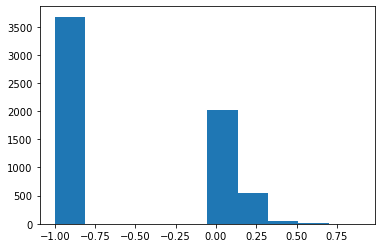

In [3]:
# Raw results

values = [results[key] for key in results]
plt.hist(values)
plt.show()
plt.close()

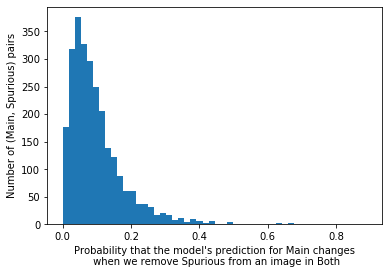

0.1
0.077


In [4]:
# Drop the pairs that we did not have enough data for

keys = [key for key in results if results[key] != -1]

values = [results[key] for key in keys]
plt.hist(values, bins = 50)
plt.xlabel("Probability that the model's prediction for Main changes\n when we remove Spurious from an image in Both")
plt.ylabel("Number of (Main, Spurious) pairs")
plt.show()
plt.close()

print(np.round(np.mean(values), 3))
print(np.round(np.median(values), 3))

In [ ]:
def group(keys):
    m_dict = {}
    s_dict = {}
    for key in keys:
        objs = key.split('-')
        main = objs[0]
        spurious = objs[1]
        
        if main in m_dict:
            m_dict[main].append(key)
        else:
            m_dict[main] = [key]
            
        if spurious in s_dict:
            s_dict[spurious].append(key)
        else:
            s_dict[spurious] = [key]     
    return m_dict, s_dict

In [ ]:
# Filter for a minimum Counterfactual Score

keys = [key for key in results if results[key] >= 0.40]

m_dict, s_dict = group(keys)
print(len(keys), len(m_dict), len(s_dict))

values = [results[key] for key in keys]
plt.hist(values)
plt.show()
plt.close()

In [ ]:
# What pairs have we identified?
pairs = []
for m in m_dict:
    for pair in m_dict[m]:
        print(pair)
        pairs.append(pair)

# Save
with open('./Pairs.json', 'w') as f:
    json.dump(pairs, f)
    
out = {}
out['Main'] = []
out['Spurious'] = []
out['P(Main)'] = []
out['P(Spurious)'] = []
out['P(Spurious|Main)'] = []
out['bias'] = []
out['ratio'] = []
for pair in pairs:
    with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
        splits = json.load(f)
        
    for key in splits:
        splits[key] = len(splits[key])
        
    n = sum(splits[v] for v in splits)
    
    out['Main'].append(pair.split('-')[0].replace('+', ' '))
    out['Spurious'].append(pair.split('-')[1].replace('+', ' '))
    out['P(Main)'].append((splits['both'] + splits['just_main']) / n)
    s =  (splits['both'] + splits['just_spurious']) / n
    out['P(Spurious)'].append(s)
    s_m = splits['both'] / (splits['both'] + splits['just_main'])
    out['P(Spurious|Main)'].append(s_m)
    out['bias'].append((s_m - s) / s)
    out['ratio'].append(splits['both'] / splits['just_main'])
    
df = pd.DataFrame.from_dict(out, orient = 'columns')

df = df.sort_values(by = ['bias'])

df = df.round(3)

df.to_csv('Pairs.csv', index = False)

In [ ]:
# Find which pairs require us to go and find more data    
for pair in pairs:
    
    with open('{}/val/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
        splits = json.load(f)
        
    for key in splits:
        if len(splits[key]) < 25:
            print('{}-{}'.format(pair, key))


In [ ]:
# Verify that using these SPs leads to accuracy gaps

with open('./ReferenceModel/results.json', 'r') as f:
    results = json.load(f)

out['tp'] = []
out['fp'] = []
out['norm'] = []
for i, pair in enumerate(pairs):
    
    both = results['{}-both'.format(pair)]
    just_main = results['{}-just_main'.format(pair)]
    just_spurious = results['{}-just_spurious'.format(pair)]
    neither = results['{}-neither'.format(pair)]
    
    out['tp'].append(both - just_main)
    
    out['fp'].append(neither - just_spurious)
    
    out['norm'] = abs(out['tp'][i]) + abs(out['fp'][i])



fig = plt.figure(figsize = (10, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

fs = 24.0
fs_tick = 15
s = 60

plt.subplot(1, 2, 1)
plt.scatter(out['bias'], out['tp'], s  = s)
plt.xticks(fontsize = fs_tick)
plt.yticks(fontsize = fs_tick)
plt.ylabel('Recall Gap', fontsize = fs)
plt.xlabel('bias', fontsize = fs)
plt.axvline(x=0, linestyle='dashed', c = 'black')
plt.axhline(y=0, linestyle='dashed', c = 'black')

plt.subplot(1, 2, 2)    
plt.scatter(out['bias'], out['fp'], s=s)
plt.ylabel('Hallucination Gap', fontsize = fs)
plt.xlabel('bias', fontsize = fs)
plt.xticks(fontsize = fs_tick)
plt.yticks(fontsize = fs_tick)
plt.axvline(x=0, linestyle='dashed', c = 'black')
plt.axhline(y=0, linestyle='dashed', c = 'black')

# plt.subplot(1, 3, 3)    
# plt.scatter(out['tp'], out['fp'], s=s)
# plt.xlabel('Recall Gap', fontsize = fs)
# plt.ylabel('Hallucination Gap', fontsize = fs)
# plt.xticks(fontsize = fs_tick)
# plt.yticks(fontsize = fs_tick)
# plt.axvline(x=0, linestyle='dashed', c = 'black')
# plt.axhline(y=0, linestyle='dashed', c = 'black')

plt.show()
plt.close()

print('Smallest l1 norm of gaps: ', np.min(out['norm']))
